In [39]:
import subprocess
import pysam

In [43]:
import pysam
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from scipy.sparse import csr_matrix
from tqdm import tqdm
#import pickle5 as pkl
#from matplotlib_scalebar.scalebar import ScaleBar
from datetime import datetime
#import umap
#umap.UMAP().fit_transform(np.random.randn(10_000, 20))

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 1000)
import subprocess

In [67]:
def sort_cnt(arr):
    npcnt=np.array(np.unique(arr,return_counts=True)).T
    dfcnt=pd.DataFrame(npcnt)
    dfcnt[1]=dfcnt[1].astype('int')
    dfcnt=dfcnt.sort_values(by=1,ascending=False)
    return dfcnt
def mtx_adata(slideseq,i,save=True):
    folds=sorted(os.listdir(slideseq))
    print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
    folds=os.listdir(slideseq) #list subfolders in a head folder of samples, the mtx features barcodes and xy files all should in the same subfolder
    adata = sc.read_mtx(f'{slideseq}/{fold}/{puck}.matched.digital_expression_matrix.mtx.gz')# load in counts matrix
    adata = adata.T
    adata.var = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_features.tsv.gz', 
                              names=['ensembl','gene'], index_col=1)# load in gene names/ids table
    barcode_xy = pd.read_table(f'{slideseq}/{fold}/{puck}_barcode_xy.txt.gz',names=['x','y'], index_col=0)# load in bead barcodes>location table
    barcodes = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_barcodes.tsv.gz', 
                             names=['barcode'], index_col=0)# load in bead barcodes list
    adata.obs=barcodes.merge(barcode_xy,left_index=True,right_index=True)
    adata.obsm['spatial']=adata.obs.values
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True,inplace=True)
    if save:
        adata.write_h5ad(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')
    return adata


In [69]:
slideseq='/n/data2/dfci/medonc/cwu/meb521/slideseq/zebra'

In [80]:
for i in range(3):
    mtx_adata(slideseq,i,save=True)

0
2022-03-11_Puck_220128_36
1
2022-03-11_Puck_220128_37
2
2022-03-11_Puck_220128_38


In [70]:
ref_fasta='/home/meb521/refs/zebra_markers.fa'
genome_dir='/home/meb521/refs/zebra_markers_ref/'

In [71]:
subprocess.call([ '/home/meb521/scripts/STAR_ref.sh', ref_fasta, genome_dir])

0

In [72]:
bam_file='/n/data2/dfci/medonc/cwu/meb521/slideseq/zebra/2022-03-11_Puck_220128_36/Puck_220128_36.matched'

In [36]:
#bam_dir='/n/data2/dfci/medonc/cwu/meb521/slideseq/zebra/2022-03-11_Puck_220128_36/Puck_220128_36.matched_unmapped.fastq.gz'

In [91]:
subprocess.call([ 'sbatch','/home/meb521/scripts/matchbam2fq.sh', bam_file])

0

In [73]:
#genome_dir=$1
input_fastq=f'{bam_file}_unmapped.fastq.gz'
out_name=f'{bam_file}_markers_mapped'

In [74]:
subprocess.call([ 'sbatch','/home/meb521/scripts/STAR_align.sh', genome_dir,input_fastq, out_name])

0

In [76]:
f_map=f'{out_name}_pri.bam'

In [77]:
samfile = pysam.AlignmentFile(f_map, 'r' ,threads=4,check_sq=False)
flags=[];reads={};i=0;save=False;extract=False
if save:
    f_name=f_map.split('.bam')[0]+'_extract.fastq'
    f= open(f_name, 'w')
for read in samfile.fetch():
    i+=1
    AS=read.get_tag('AS');mapq=read.mapping_quality
    if AS>25:#20*'A' not in read.seq:# and mapq==60:
        ref=read.reference_name
        #if ref=='4324143':
        #    print(f'>{read.qname}','\n',read.seq)
        if save:
            qstrt=read.query_alignment_start;qend=read.query_alignment_end
            newnamef=f'{read.qname}_{qstrt}_{qend}_{read.flag}_{ref}'
            if extract:
                sub_seq=read.seq[qstrt:qend]
                sub_qual=read.qual[qstrt:qend]
                f.write(f'@{newnamef}\n')
                f.write(f'{sub_seq}\n')
                f.write('+\n')
                f.write(f'{sub_qual}\n')
            else:
                f.write(f'@{newnamef}\n')
                f.write(f'{read.seq}\n')
                f.write('+\n')
                f.write(f'{read.qual}\n')
            
        reads[read.qname]=ref
        flags.append([ref,read.rlen,read.qlen,AS,read.reference_start,mapq,read.flag])
        
    if i>20000000: break
if save:
    f.close()
    subprocess.call([ 'pigz', '-f', f_name ])

In [78]:
trns=[f[0] for f in flags]
stats=[f[1:] for f in flags]
stats=pd.DataFrame(np.array(stats))
cnt_trns=sort_cnt(trns)
#cnt_trns['species']=cnt_trns[0].apply(lambda x: map_names[x])
#cnt_trns['species']=cnt_trns[0].apply(lambda x: seq_to_name[x])

In [79]:
cnt_trns

,0,1
2,TagBFP,42
0,EGFP,33
3,mCherry,33
1,TRBC1,1


111


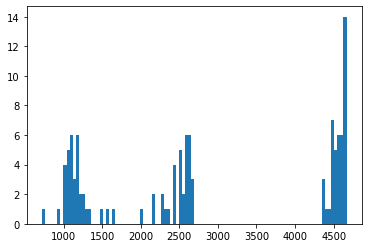

In [66]:
arr=np.array([l for l in stats[3] if l >0 and l<30000])
print(len(arr))
plt.hist(arr,bins=100);

In [82]:
bam_file

'/n/data2/dfci/medonc/cwu/meb521/slideseq/zebra/2022-03-11_Puck_220128_36/Puck_220128_36.matched'

In [86]:
folds=sorted(os.listdir(slideseq))

In [87]:
i=0
print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
adata=sc.read(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')
f_match=f'{slideseq}/{fold}/{puck}.matched_unmapped.bam'

2022-03-11_Puck_220128_36


In [ ]:
adata

[<AxesSubplot:title={'center':'total_counts'}, xlabel='spatial1', ylabel='spatial2'>]

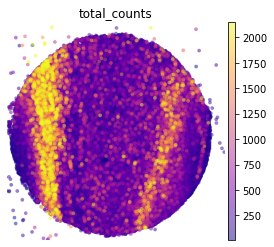

In [92]:
sc.pl.spatial(adata,color='total_counts',show=False,
                  spot_size=80,frameon=False,vmax='p99.3',
                  crop_coord=[300,5000,5000,300],alpha=.5,cmap='plasma')

In [ ]:
bcs=[];trans=[];bac_dic={}
samfile = pysam.AlignmentFile(f_match, 'rb', check_sq=False)
for read in tqdm(samfile.fetch(until_eof=True)):
    if reads.get(read.qname) is not None:
        #BC=read.get_tag('XC')+'-1'#.split('-')[0]
        BC=read.get_tag('XB')#.split('-')[0]
        UMI=read.get_tag('XM')
        trans.append(reads[read.qname])
        bcs.append(BC)
        try:
            bac_dic[reads[read.qname]].append([BC,UMI])
        except:
            bac_dic[reads[read.qname]]=[[BC,UMI]]
    

14809596it [00:31, 471045.09it/s]


In [ ]:
bcs_uni=np.unique(bcs)

print(bcs_uni.shape)

trans_uni=np.unique(trans)

(34,)


In [ ]:
len(set(adata.obs.index) & set(bcs_uni))

34

### make adata

In [110]:
bac_np = np.zeros( (len(bcs_uni),len(trans_uni)) )
bac_df = pd.DataFrame(bac_np, index=bcs_uni, columns=trans_uni)

for bac in trans_uni:
    uniques = np.unique(bac_dic[bac], axis=0) # all unique pairs of bc and umi
    if len(uniques)>0:
        bcs, cnts = np.unique(uniques[:,0], return_counts=True) # all barcodes
        for i in range(len(cnts)):
            if cnts[i]>0:
                bac_df.at[bcs[i],bac]+=cnts[i]

bac_df=AnnData(bac_df)
bac_df.X = csr_matrix(bac_df.X)
sc.pp.filter_genes(bac_df, min_counts=1)
sc.pp.filter_cells(bac_df, min_counts=1)
sc.pp.calculate_qc_metrics(bac_df, percent_top=None, log1p=None, inplace=True)

In [99]:
bac_df.obs=pd.merge(bac_df.obs,adata.obs[['x','y']],how='left',left_index=True,right_index=True)
bac_df.obsm['spatial']=bac_df.obs[['x','y']].values


In [ ]:
bac_df.obs=pd.merge(bac_df.obs,adata.obs[['x','y']],how='left',left_index=True,right_index=True)
bac_df.obsm['spatial']=bac_df.obs[['x','y']].values


In [100]:
bac_df

AnnData object with n_obs × n_vars = 34 × 4
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'x', 'y'
    var: 'n_counts', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'

[<AxesSubplot:title={'center':'total_counts'}, xlabel='spatial1', ylabel='spatial2'>]

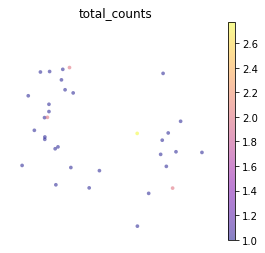

In [101]:
sc.pl.spatial(bac_df,color='total_counts',show=False,
                  spot_size=80,frameon=False,vmax='p99.3',
                  crop_coord=[300,5000,5000,300],alpha=.5,cmap='plasma')

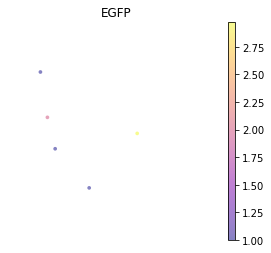

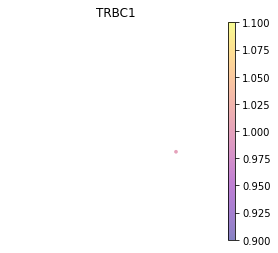

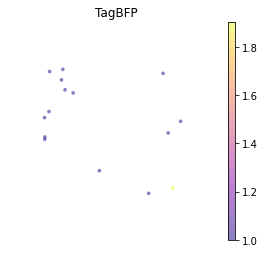

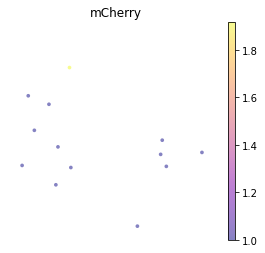

In [109]:
for gene in bac_df.var.index:
    sc.pl.spatial(bac_df[bac_df[:,gene].X>0],color=gene,spot_size=80,frameon=False,vmax='p99.3',
                  crop_coord=[300,5000,5000,300],alpha=.5,cmap='plasma')